In [75]:
import pandas as pd
import numpy as np
from scipy import stats
import random
import warnings

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import squarify
#import plotly.graph_objects as go
#import plotly.express as px
%matplotlib inline


# Set random seed
rs = 42

# Ignore warnings
warnings.filterwarnings("ignore")

# Set color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

In [98]:
def preprocess(df, missing_num=0, missing_cat=0):
    df=df.copy()
     # Change columns titles to lower case
    df.columns=df.columns.str.lower().str.replace(' ', '-').to_list()
    # get numerical columns
    num_cols = [cols for cols in df.select_dtypes('number').columns if cols!= 'id' and cols!='depression']
   
    # get categorical columns
    cat_cols=df.columns[df.dtypes=='O'].to_list()
    # Change categorical column content to lower case
    for col in cat_cols:
        df[col]=df[col].str.lower()
    if missing_cat=='Mode':
        for col in cat_cols:
            # fill in all NaN by the mode
            mode=df[col].mode()
            df[col] = df[col].fillna(mode.iloc[0])
    elif missing_cat==0:
        threshold=100
        for col in cat_cols:
            # fill in all NaN by 'missing'
            df[col] = df[col].fillna('missing')
            # computes the frequency of each unique value in the column, including NaN values
            # sets the value of the column to "noise" for all rows where the boolean condition (value count is less than threshold) is true.
            df.loc[df[col].value_counts(dropna=False)[df[col]].values < threshold, col] = "noise"
    else:
        print('Enter the correct value for missing_cat')
    if missing_num=='Mean': 
        for col in num_cols:
            mean=df[col].mean()
            df[col]=df[col].fillna(mean)
    elif missing_num=='Median':
        for col in num_cols:
            median=df[col].median()
            df[col]=df[col].fillna(median)
    elif missing_num==0:
         for col in num_cols:
            df[col]=df[col].fillna(0)
    else:
        print('Enter the correct value for missing_num')
    # remove name column as it does not affect the target
    cat_cols.remove('name')
    features=num_cols+cat_cols
    
    
    

    return features, df

    

## Load

In [99]:
train=pd.read_csv('data/train.csv')
original=pd.read_csv('data/final_depression_dataset_1.csv')


In [100]:
train.shape, original.shape  # training data is 140,700 rows and original is 2,556 rows

((140700, 20), (2556, 19))

In [101]:
#train.head()

In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [103]:
# change all columns to lower case and replace space by a dash
train.columns=train.columns.str.lower().str.replace(' ', '-').str.replace('/', '-').to_list()
numerical=train.select_dtypes(exclude='object').columns.to_list()  # 10 but only 8 remains after dropping id and target
categorical=train.select_dtypes(include='object').columns.to_list() # 10 # Name will be dropped


In [104]:
numerical, categorical  # ten cols from each

(['id',
  'age',
  'academic-pressure',
  'work-pressure',
  'cgpa',
  'study-satisfaction',
  'job-satisfaction',
  'work-study-hours',
  'financial-stress',
  'depression'],
 ['name',
  'gender',
  'city',
  'working-professional-or-student',
  'profession',
  'sleep-duration',
  'dietary-habits',
  'degree',
  'have-you-ever-had-suicidal-thoughts-?',
  'family-history-of-mental-illness'])

In [105]:

# Convert the content of all colums to lower case
for col in categorical:
    train[col]=train[col].str.lower()


### Exploratory Data Analysis

#### Missing Values

In [169]:
# get a list of columns that have missing values
missing_values_columns=train.isnull().sum().sort_values(ascending=False)[train.isnull().sum().sort_values(ascending=False)!=0].index.to_list()

missing_values_columns


['study-satisfaction',
 'academic-pressure',
 'cgpa',
 'profession',
 'work-pressure',
 'job-satisfaction',
 'financial-stress',
 'dietary-habits',
 'degree']

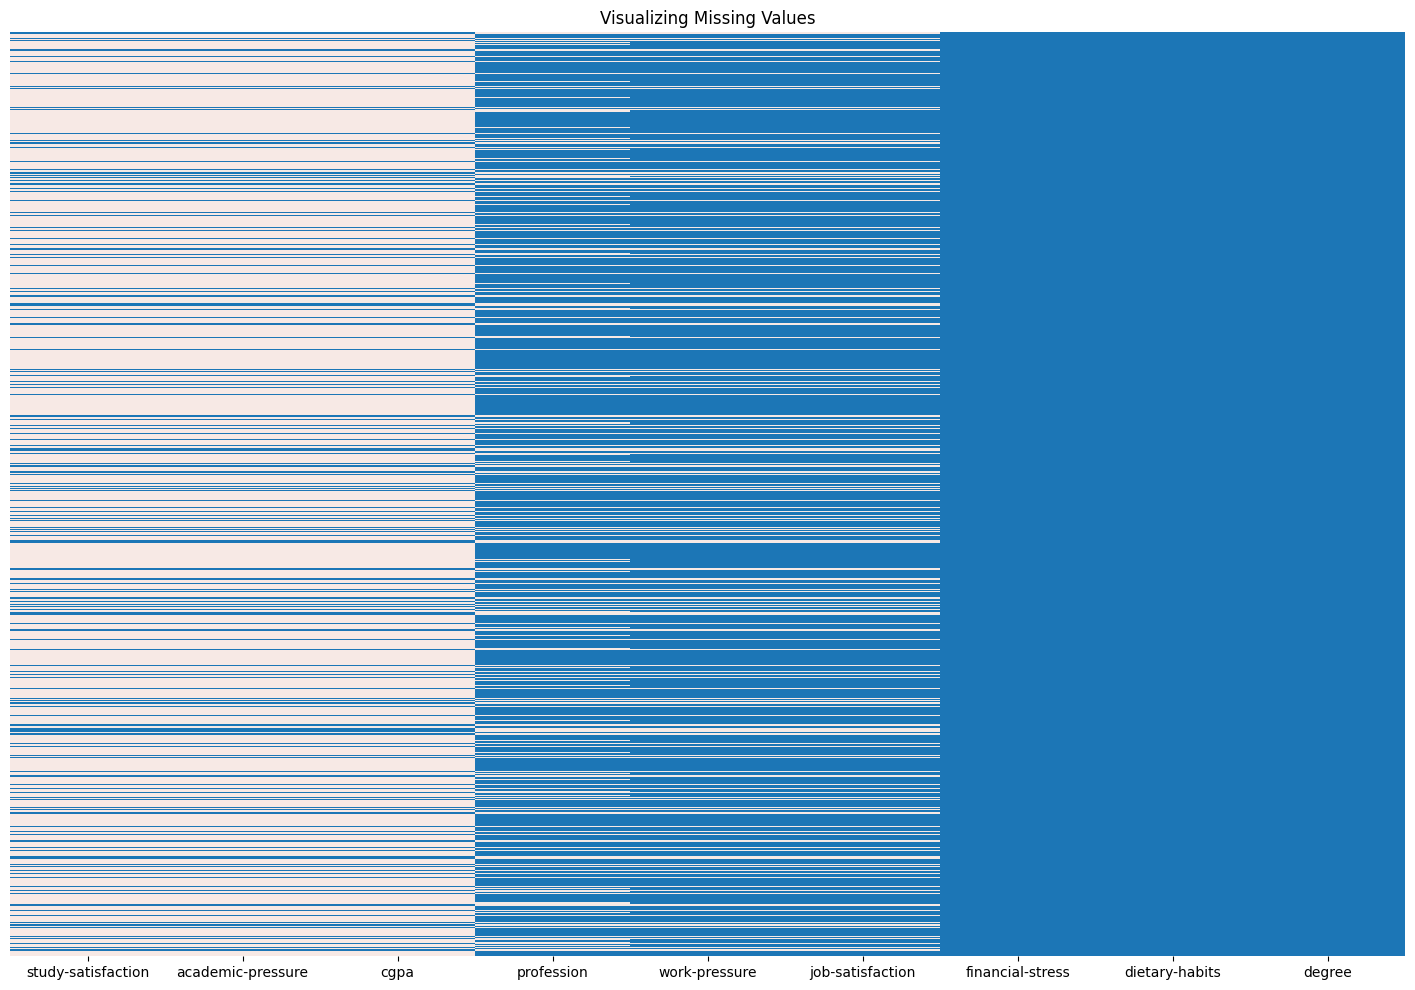

In [170]:
plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(train[missing_values_columns].isnull(), cbar=False, cmap=sns.color_palette(colors), yticklabels=False);

In [172]:
# percentage of missing values
train[missing_values_columns].isnull().sum()/train.shape[0]

study-satisfaction    0.801727
academic-pressure     0.801727
cgpa                  0.801720
profession            0.260341
work-pressure         0.198422
job-satisfaction      0.198365
financial-stress      0.000028
dietary-habits        0.000028
degree                0.000014
dtype: float64

In [240]:
train['working-professional-or-student'].value_counts(normalize=True)  # only 20% are students

working-professional-or-student
working professional    0.801699
student                 0.198301
Name: proportion, dtype: float64

In [252]:
train[train['working-professional-or-student']=='working professional'].profession.value_counts(dropna=False, normalize=True) # non students are mostly working

profession
teacher           0.220747
NaN               0.077687
content writer    0.069256
architect         0.038671
consultant        0.037491
                    ...   
moderate          0.000009
analyst           0.000009
pranav            0.000009
visakhapatnam     0.000009
yuvraj            0.000009
Name: proportion, Length: 65, dtype: float64

In [254]:
train[
train['working-professional-or-student']=='student'
].profession.value_counts(dropna=False, normalize=True) #  Students are mostly not working and 99% of NaN values in the profession field

profession
NaN                       0.998781
architect                 0.000287
teacher                   0.000215
student                   0.000108
digital marketer          0.000108
content writer            0.000072
chef                      0.000072
pharmacist                0.000072
doctor                    0.000072
civil engineer            0.000036
ux/ui designer            0.000036
educational consultant    0.000036
manager                   0.000036
lawyer                    0.000036
entrepreneur              0.000036
Name: proportion, dtype: float64

In [211]:
train['age'].median()

np.float64(42.0)

In [187]:
train[train['working-professional-or-student']=='working professional'].cgpa.value_counts(dropna=False, normalize=True) # 99.99% of values are null

cgpa
NaN     0.999947
8.14    0.000009
8.04    0.000009
8.11    0.000009
9.72    0.000009
5.42    0.000009
8.24    0.000009
Name: proportion, dtype: float64

In [197]:
train[train['working-professional-or-student']=='student'].cgpa.value_counts(dropna=False, normalize=True) # 99.99% of values are null
train[train['working-professional-or-student']=='student'].cgpa.isnull().sum()/train[train['working-professional-or-student']=='student'].shape[0] # very negligble missing values

np.float64(0.00032256908354539264)

### Since only students have cgpa and not professional, I will drop this value further ahead after assessing how it affect the target value

In [198]:
train.describe()

,id,age,academic-pressure,work-pressure,cgpa,study-satisfaction,job-satisfaction,work-study-hours,financial-stress,depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


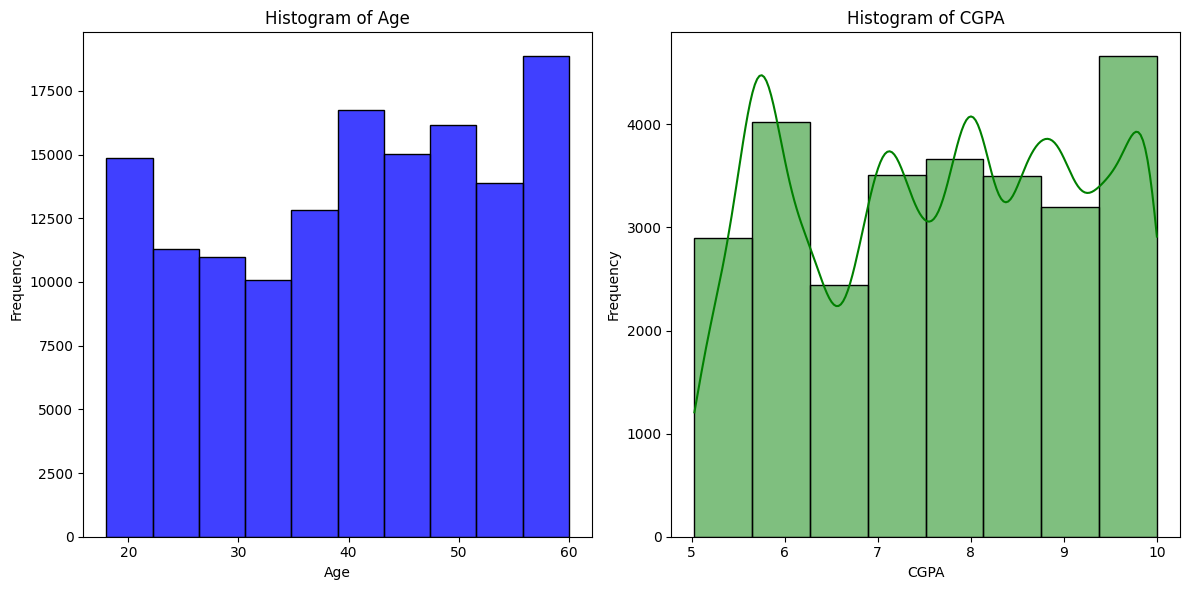

In [217]:
# Plotting histograms
plt.figure(figsize=(12, 6))  # Set the figure size

# Histogram for the 'Age' column
plt.subplot(1, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.histplot(df['age'], bins=10, kde=False, color='blue')
plt.title('Histogram of Age')  # Set title of the plot
plt.xlabel('Age')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

# Histogram for the 'CGPA' column
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df['cgpa'].dropna(), bins=8, kde=True, color='green')  # KDE overlay for smoothing curve
plt.title('Histogram of CGPA')  # Set title of the plot
plt.xlabel('CGPA')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

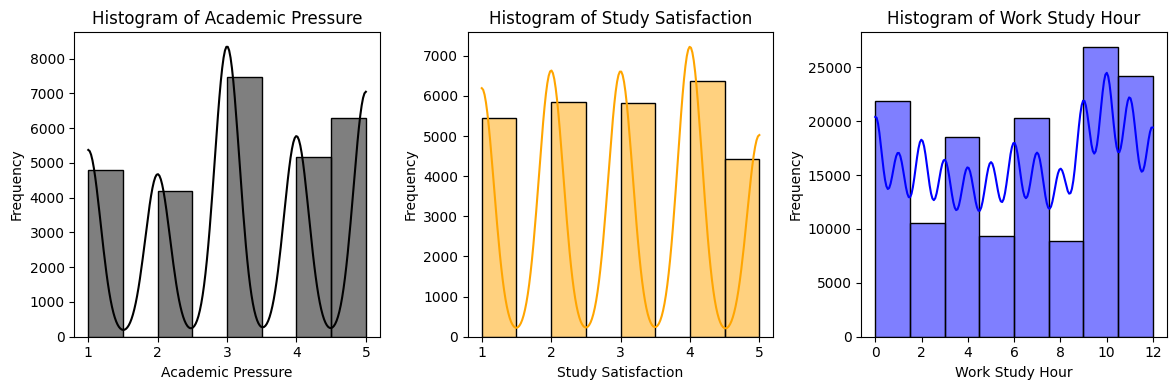

In [234]:
# Plotting histograms
plt.figure(figsize=(12, 4))  # Set the figure size

# Histogram for the 'Academic Pressure' column
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 2nd subplot
sns.histplot(train['academic-pressure'].dropna(), bins=8, kde=True, color='black')  # KDE overlay for smoothing curve
plt.title('Histogram of Academic Pressure')  # Set title of the plot
plt.xlabel('Academic Pressure')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

# Histogram for the 'Study-Satisfaction' column
plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(train['study-satisfaction'].dropna(), bins=8, kde=True, color='orange')  # KDE overlay for smoothing curve
plt.title('Histogram of Study Satisfaction')  # Set title of the plot
plt.xlabel('Study Satisfaction')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

# Histogram for the 'Work Study Hours' column
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
sns.histplot(train['work-study-hours'].dropna(), bins=8, kde=True, color='blue')  # KDE overlay for smoothing curve
plt.title('Histogram of Work Study Hour')  # Set title of the plot
plt.xlabel('Work Study Hour')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

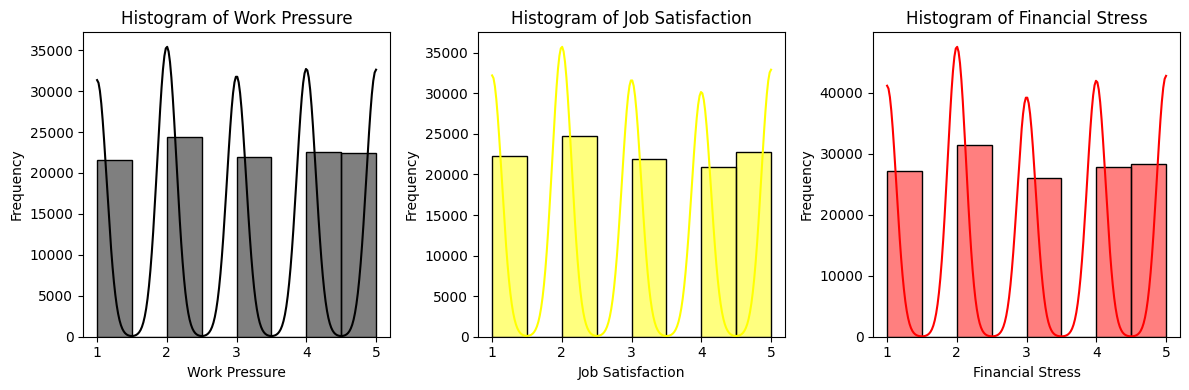

In [236]:
# Plotting histograms
plt.figure(figsize=(12, 4))  # Set the figure size
# Histogram for the 'Work Pressure' column
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 2nd subplot
sns.histplot(train['work-pressure'].dropna(), bins=8, kde=True, color='black')  # KDE overlay for smoothing curve
plt.title('Histogram of Work Pressure')  # Set title of the plot
plt.xlabel('Work Pressure')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

# Histogram for the 'Job Satisfaction' column
plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df['job-satisfaction'].dropna(), bins=8, kde=True, color='yellow')  # KDE overlay for smoothing curve
plt.title('Histogram of Job Satisfaction')  # Set title of the plot
plt.xlabel('Job Satisfaction')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

# Histogram for the 'Financial Stress' column
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df['financial-stress'].dropna(), bins=8, kde=True, color='red')  # KDE overlay for smoothing curve
plt.title('Histogram of Financial Stress')  # Set title of the plot
plt.xlabel('Financial Stress')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()
# Histogram for the 'Work Pressure' column


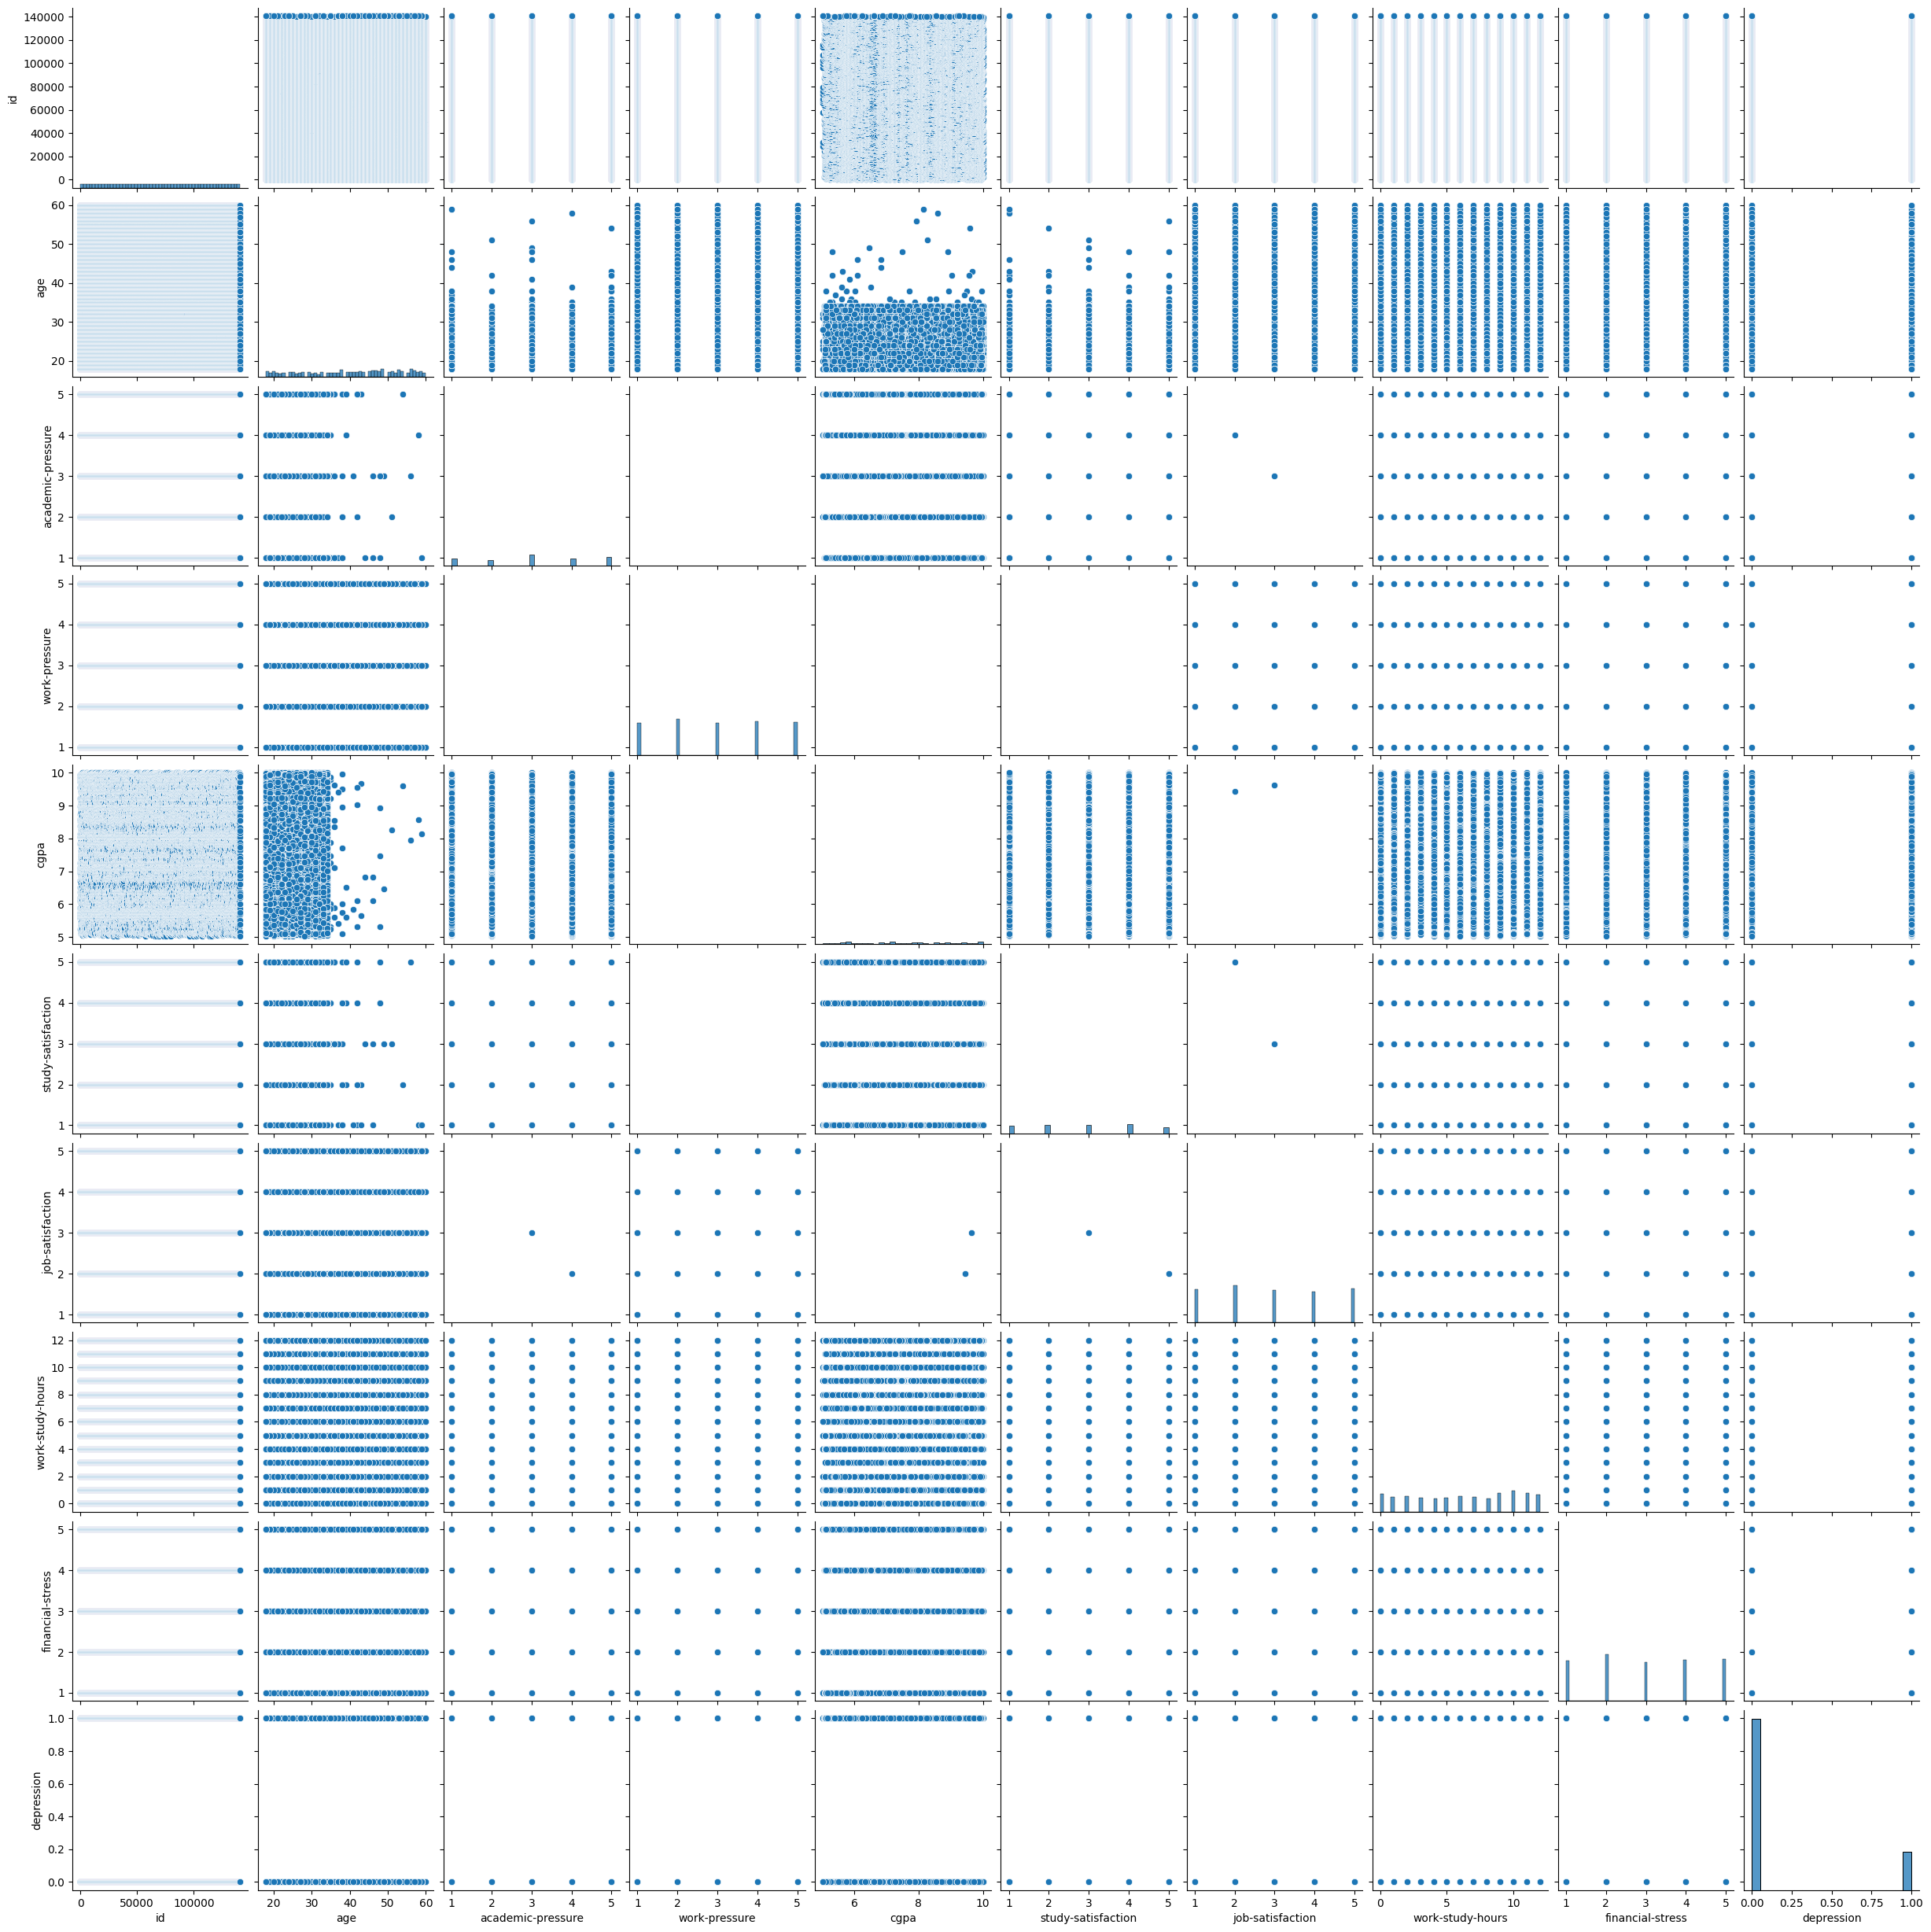

In [238]:
sns.pairplot(train)

In [54]:
# fill NaN with mode for categorical values
for col in categorical:
    # fill in all NaN by the mode
    mode=train[col].mode()
    train[col] = train[col].fillna(mode.iloc[0])

In [55]:
# fill NaN with median for numerical values
for col in numerical:
    # fill in all NaN by the median
    median=train[col].median()
    train[col] = train[col].fillna(median)

In [56]:
train.isnull().sum()/train.shape[0]   , original.isnull().sum()/original.shape[0]

(id                                       0.0
 name                                     0.0
 gender                                   0.0
 age                                      0.0
 city                                     0.0
 working-professional-or-student          0.0
 profession                               0.0
 academic-pressure                        0.0
 work-pressure                            0.0
 cgpa                                     0.0
 study-satisfaction                       0.0
 job-satisfaction                         0.0
 sleep-duration                           0.0
 dietary-habits                           0.0
 degree                                   0.0
 have-you-ever-had-suicidal-thoughts-?    0.0
 work-study-hours                         0.0
 financial-stress                         0.0
 family-history-of-mental-illness         0.0
 depression                               0.0
 dtype: float64,
 Name                                     0.000000
 Gender     

## comparison between both data types
They have almost the same proportions 

In [57]:
train.depression.value_counts(normalize=True) ,original.Depression.value_counts(normalize=True)

(depression
 0    0.818287
 1    0.181713
 Name: proportion, dtype: float64,
 Depression
 No     0.821987
 Yes    0.178013
 Name: proportion, dtype: float64)

In [58]:
# check for duplicates
train.duplicated().sum()

np.int64(0)

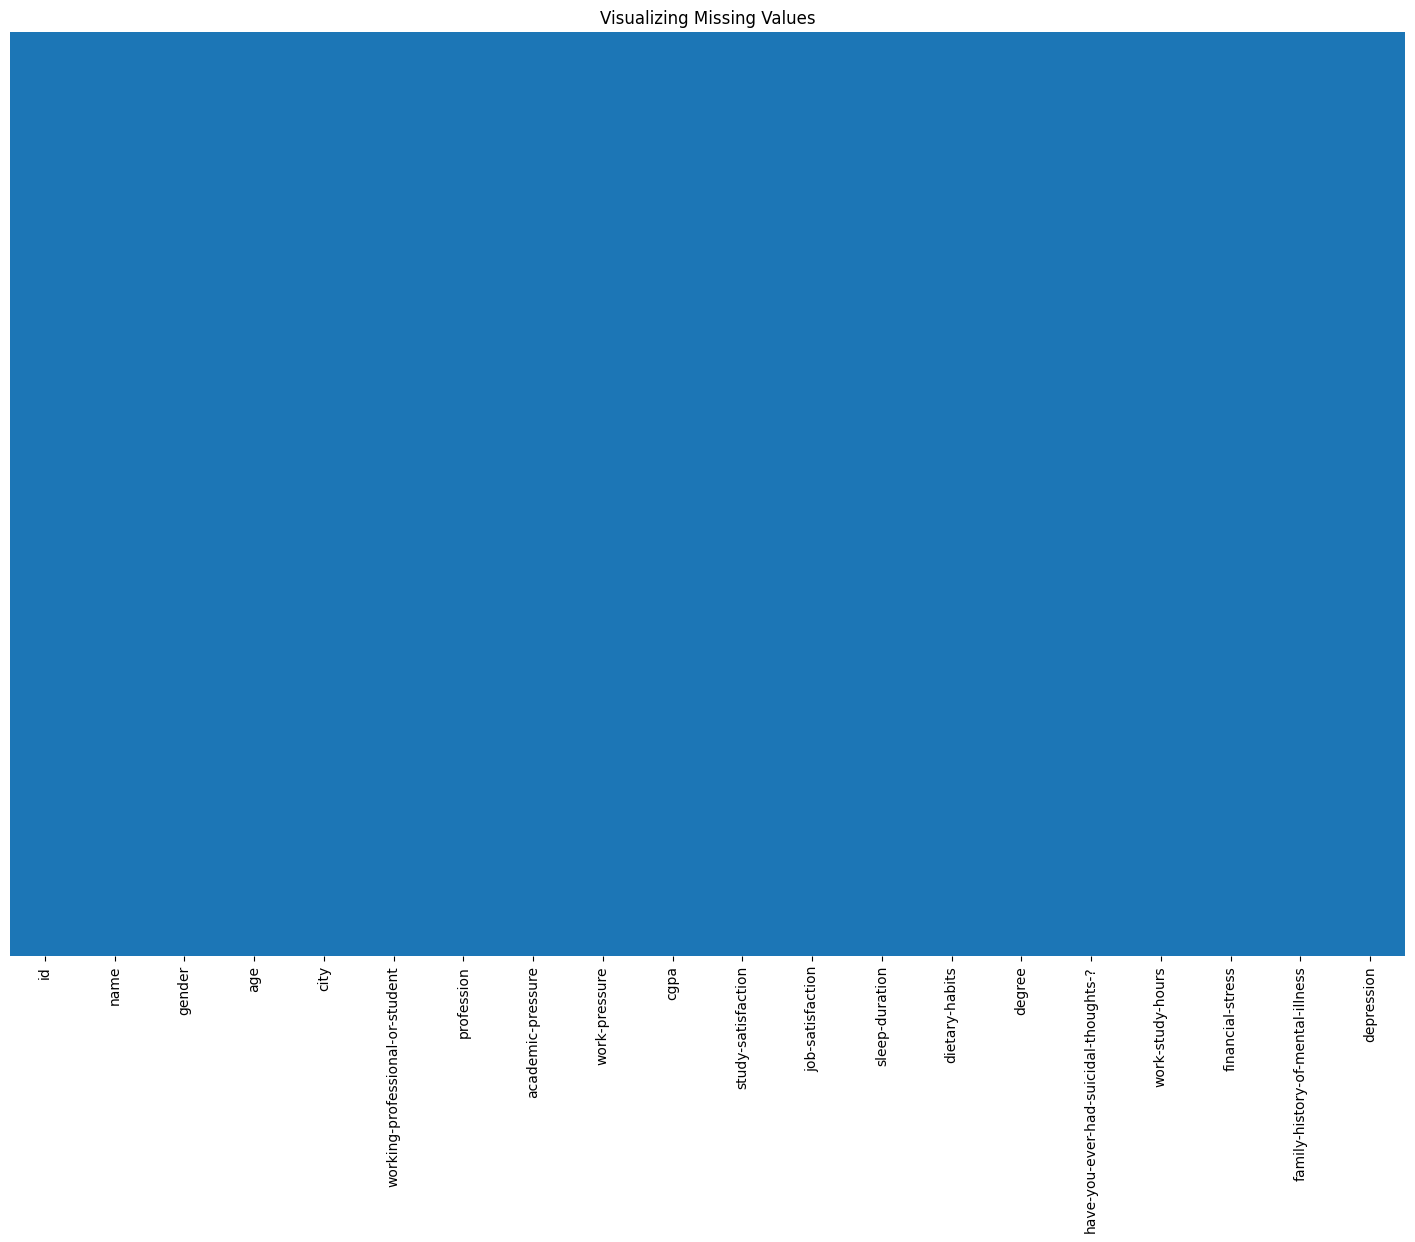

In [59]:
plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(train.isnull(), cbar=False, cmap=sns.color_palette(colors), yticklabels=False);

## Clean and Explore

In [60]:
for column in categorical:
    num_unique = train[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")

'name' has 422 unique categories.
'gender' has 2 unique categories.
'city' has 98 unique categories.
'working-professional-or-student' has 2 unique categories.
'profession' has 64 unique categories.
'sleep-duration' has 36 unique categories.
'dietary-habits' has 23 unique categories.
'degree' has 115 unique categories.
'have-you-ever-had-suicidal-thoughts-?' has 2 unique categories.
'family-history-of-mental-illness' has 2 unique categories.


In [61]:
numerical

['id',
 'age',
 'academic-pressure',
 'work-pressure',
 'cgpa',
 'study-satisfaction',
 'job-satisfaction',
 'work-study-hours',
 'financial-stress',
 'depression']

In [62]:
categorical

['name',
 'gender',
 'city',
 'working-professional-or-student',
 'profession',
 'sleep-duration',
 'dietary-habits',
 'degree',
 'have-you-ever-had-suicidal-thoughts-?',
 'family-history-of-mental-illness']

In [63]:
#sns.countplot(train['depression'])

In [64]:
# Print top 10 unique value counts for each categorical column
for column in categorical:
    print(f"\nTop value counts in '{column}':\n{train[column].value_counts().head(10)}")


Top value counts in 'name':
name
rohan          3178
aarav          2336
rupak          2176
aaradhya       2045
anvi           2035
raghavendra    1877
vani           1657
tushar         1596
ritvik         1589
shiv           1568
Name: count, dtype: int64

Top value counts in 'gender':
gender
male      77464
female    63236
Name: count, dtype: int64

Top value counts in 'city':
city
kalyan           6591
patna            5924
vasai-virar      5765
kolkata          5689
ahmedabad        5613
meerut           5528
ludhiana         5226
pune             5210
rajkot           5207
visakhapatnam    5176
Name: count, dtype: int64

Top value counts in 'working-professional-or-student':
working-professional-or-student
working professional    112799
student                  27901
Name: count, dtype: int64

Top value counts in 'profession':
profession
teacher             61536
content writer       7814
architect            4370
consultant           4229
hr manager           4022
pharmacist  

In [65]:
print("The skewness of columns:")
print(train[numerical].skew())

The skewness of columns:
id                    0.000000
age                  -0.217977
academic-pressure     0.253782
work-pressure         0.020206
cgpa                 -0.572607
study-satisfaction   -0.191931
job-satisfaction      0.048697
work-study-hours     -0.128169
financial-stress      0.035603
depression            1.650852
dtype: float64


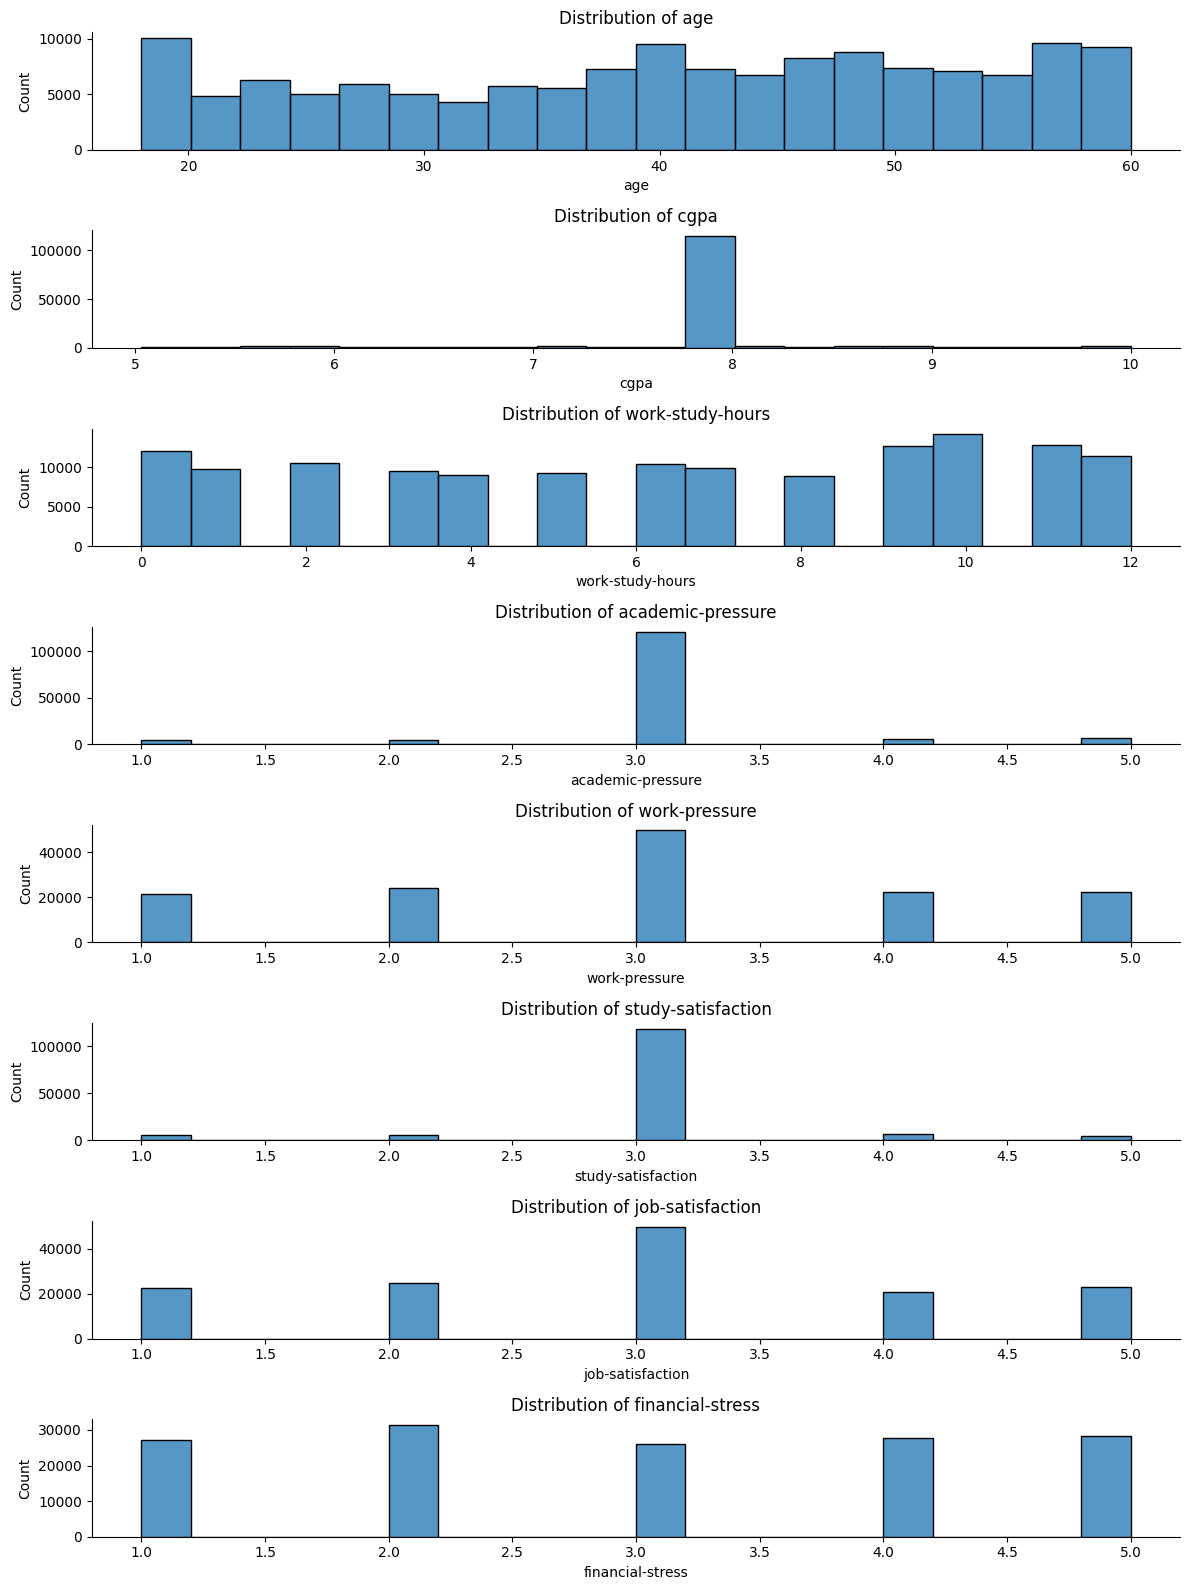

In [71]:
numerical_columns_to_plot = ["age", "cgpa", "work-study-hours", 
                             'academic-pressure', 'work-pressure', 'study-satisfaction',
                             'job-satisfaction', 'financial-stress',]

plt.figure(figsize=(12, 16)) 

for i, column in enumerate(numerical_columns_to_plot):
    plt.subplot(8, 1, i+1)
    sns.histplot(data=train, x=column, kde=False, bins=20, color=colors[0])
    plt.title(f'Distribution of {column}')
    sns.despine()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

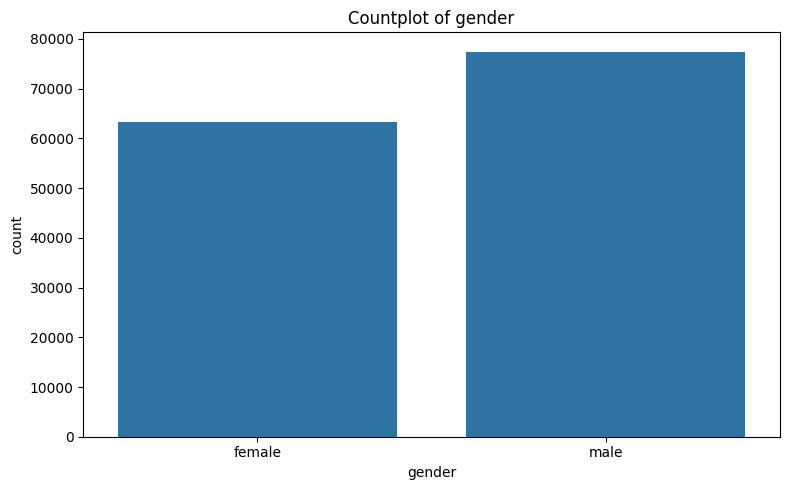

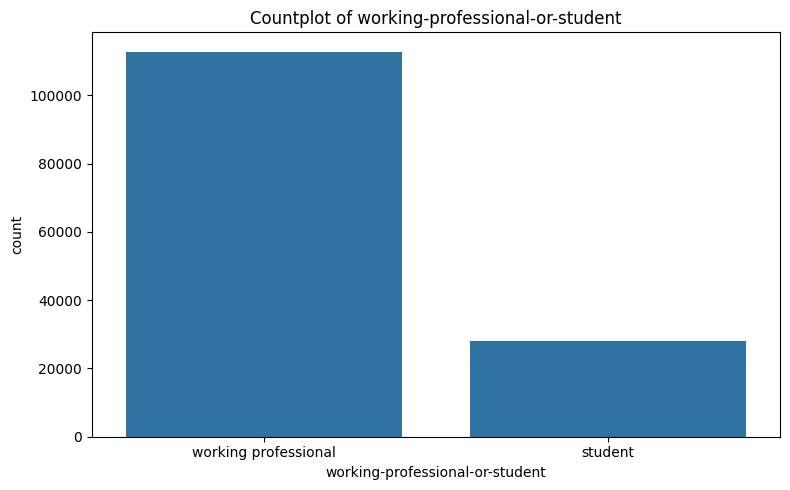

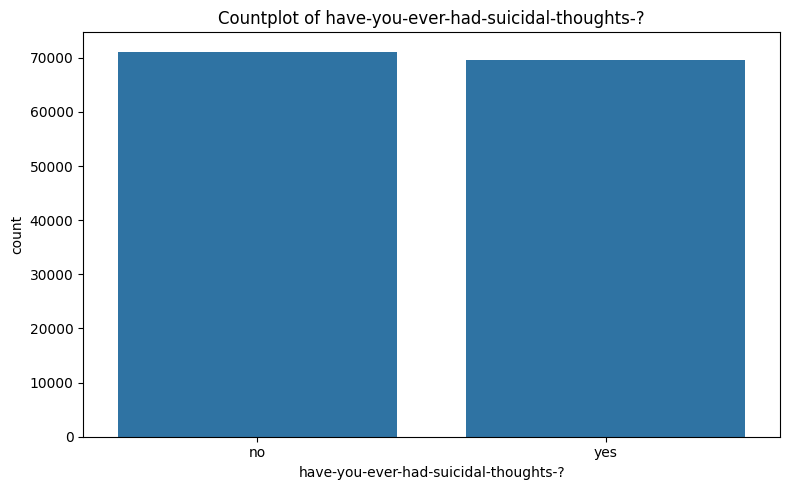

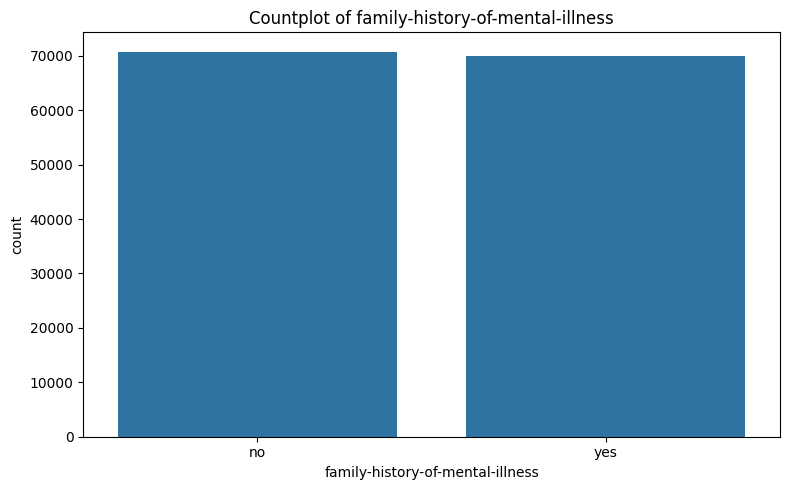

In [69]:
categorical_columns_to_plot = ['gender',

 'working-professional-or-student',
 'have-you-ever-had-suicidal-thoughts-?',
 'family-history-of-mental-illness']   # removed dietary habits, sleep duration, profession, degree and city as they have too many unique values

# Plot countplots for each categorical column
for column in categorical_columns_to_plot:
    
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train, x=column)
    plt.title(f'Countplot of {column}')
    
    plt.tight_layout()
    plt.show()
    
 

### Feature Importances

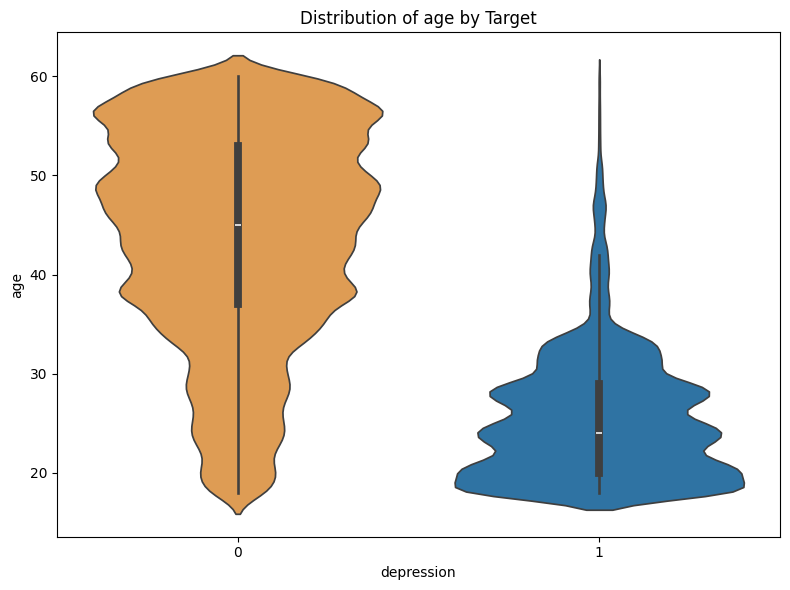

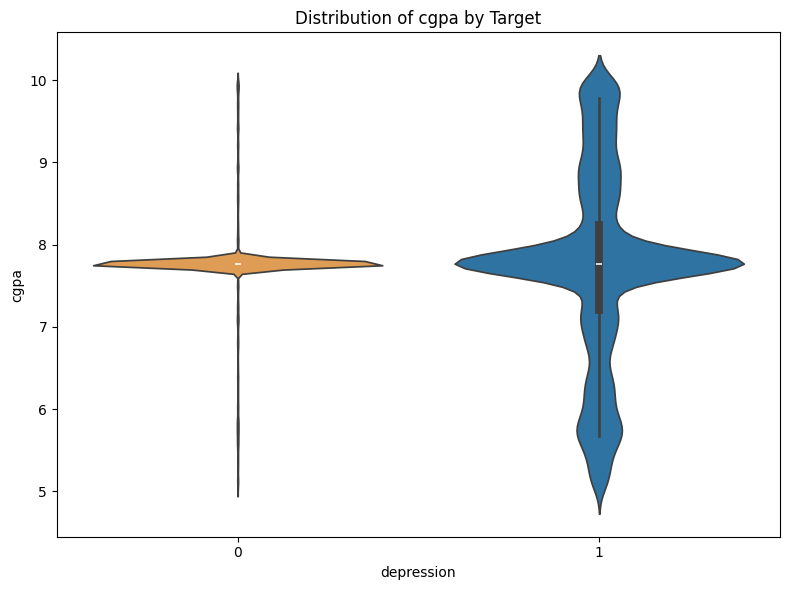

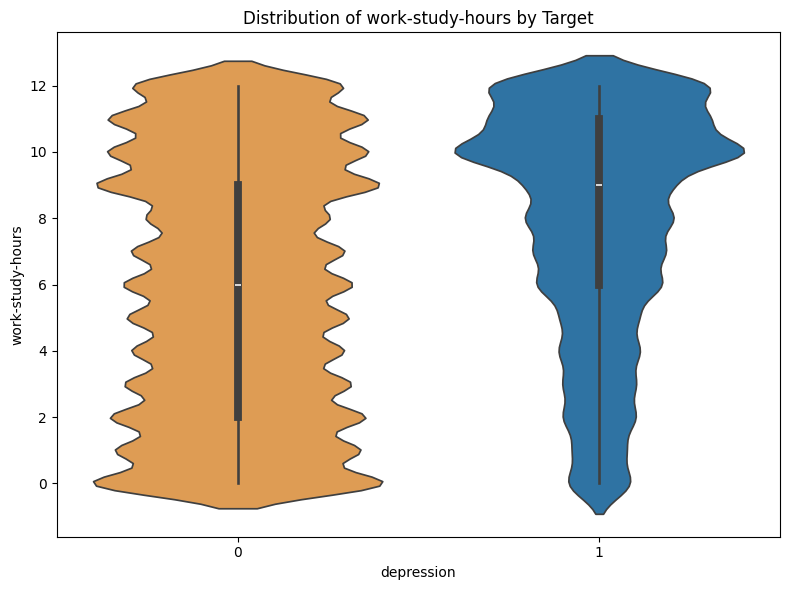

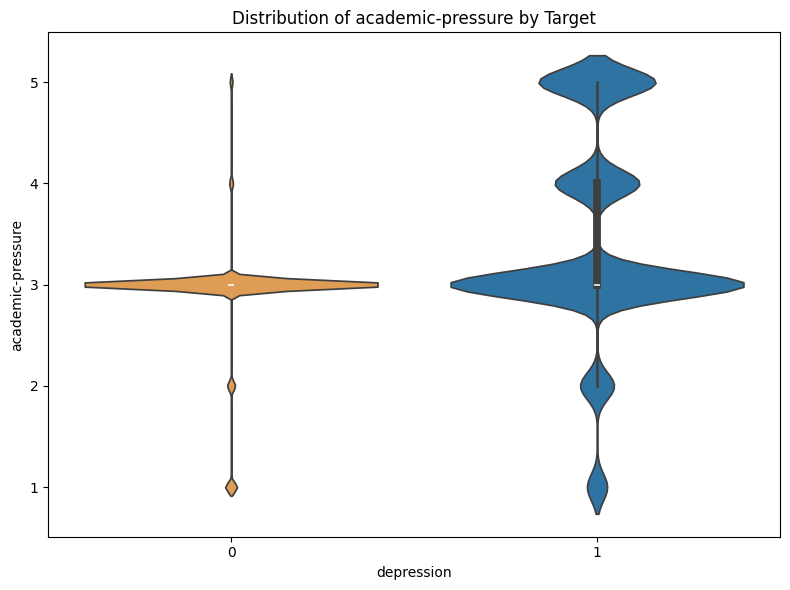

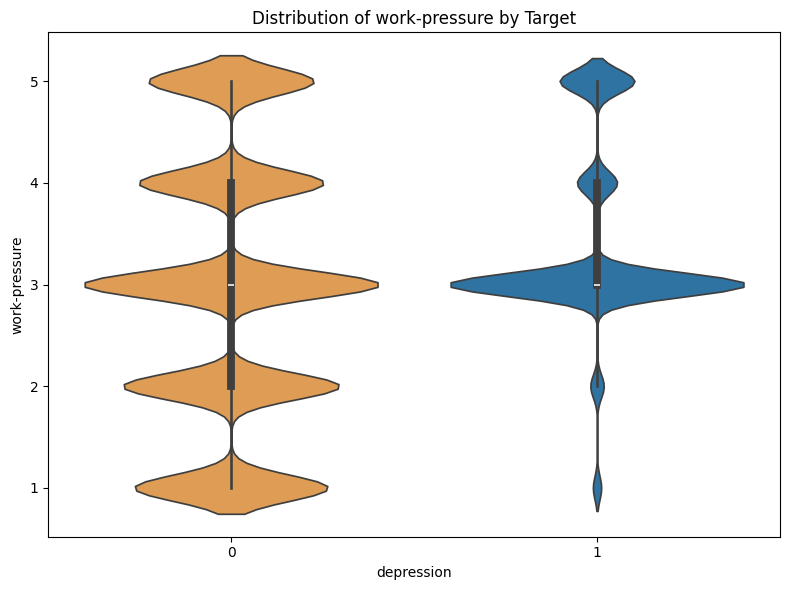

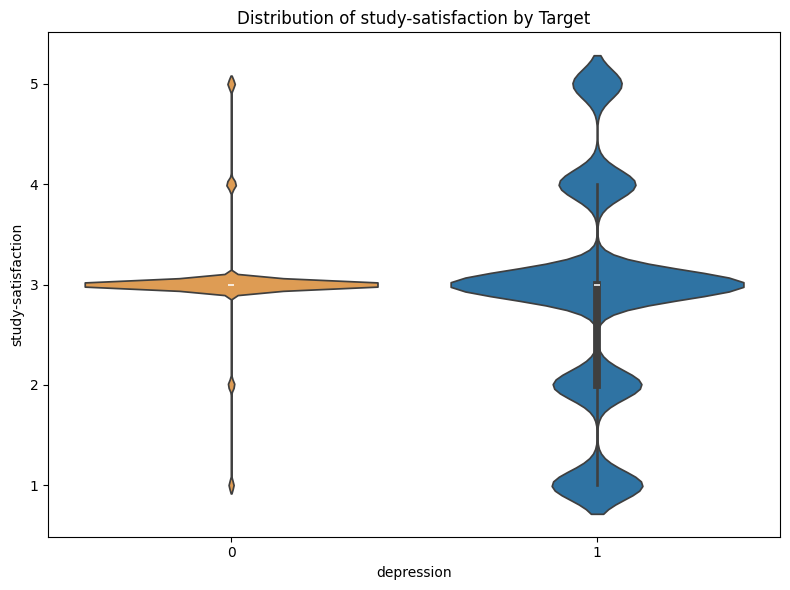

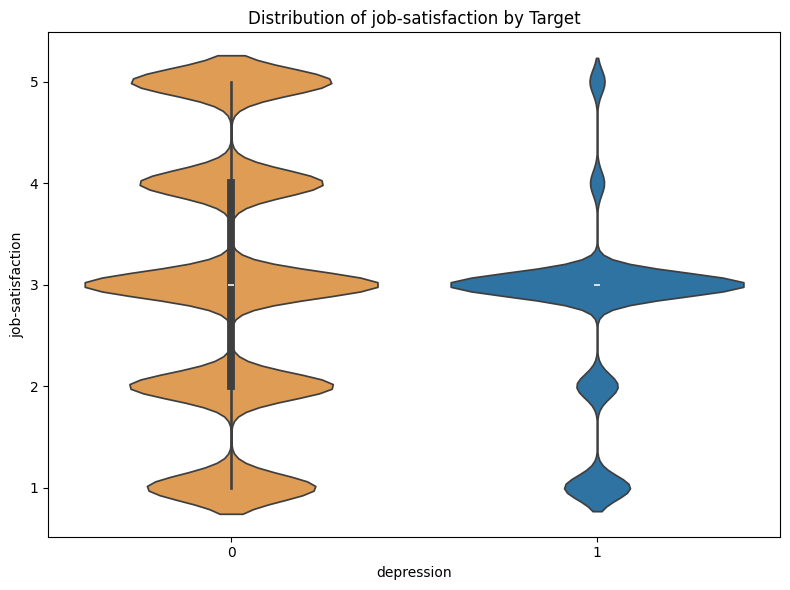

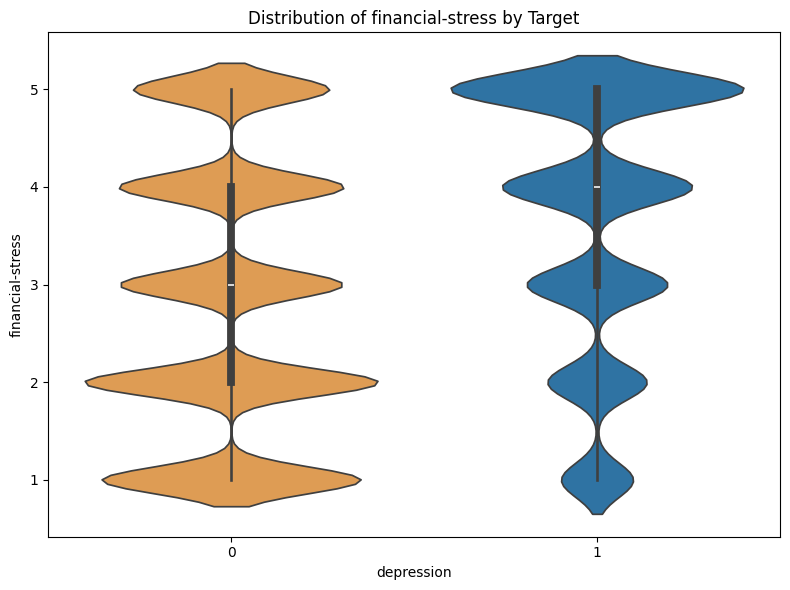

In [74]:
bi_palette = [colors[3], colors[0]]
target_column='depression'
for column in numerical_columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=train, x=target_column, y=column, palette=bi_palette) 
    plt.title(f'Distribution of {column} by Target')

    plt.tight_layout()
    plt.savefig(column)
    plt.show()
    

In [ ]:
cmap = LinearSegmentedColormap.from_list("custom_cmap", bi_palette)

# Loop through each categorical column in your list
for column in categorical_columns_to_plot: 
    # Stacked Bar Plot
    pd.crosstab(train[column], train[target_column]).plot(kind='bar', stacked=True, colormap=cmap, figsize=(8, 6))
    plt.title(f"Stacked Bar Plot of {column} and Target")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()


In [67]:
train.Profession.value_counts()[:20]
train.Profession.value_counts().nlargest(20)

AttributeError: 'DataFrame' object has no attribute 'Profession'

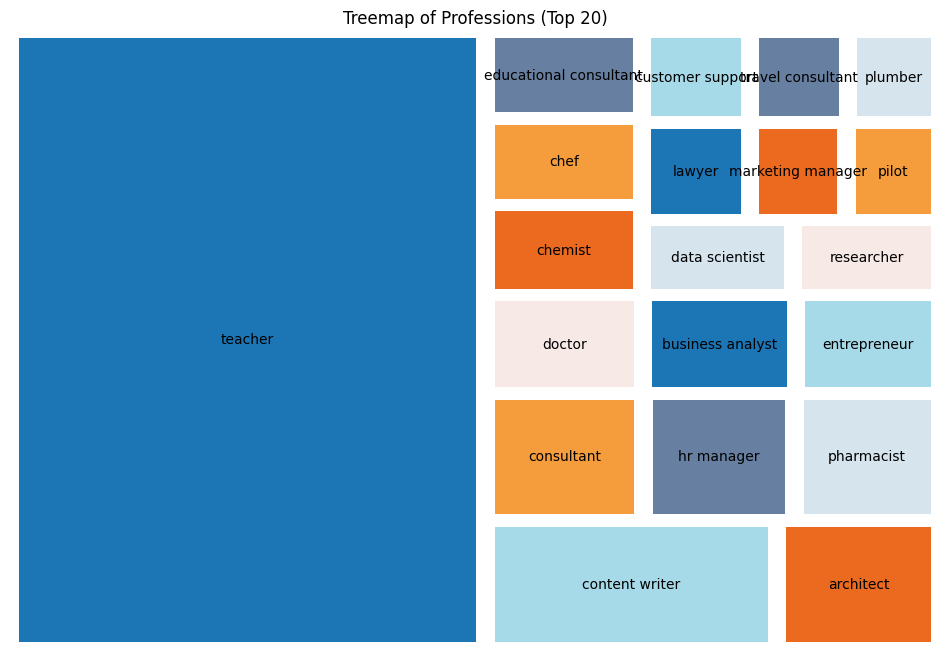

In [35]:
# Calculate frequencies
value_counts = train['profession'].value_counts()
sizes = value_counts.values[:20]  # Show only the top 20 for readability

# Modify specific labels to show on two lines and limit to top 20 labels
labels = [
    "Customer\nSupport" if label == "Customer Support" else
    "Marketing\nManager" if label == "Marketing Manager" else
    label
    for label in value_counts.index[:20]
]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, pad=True)
plt.title(f"Treemap of Professions (Top 20)")
plt.axis("off")
plt.show()

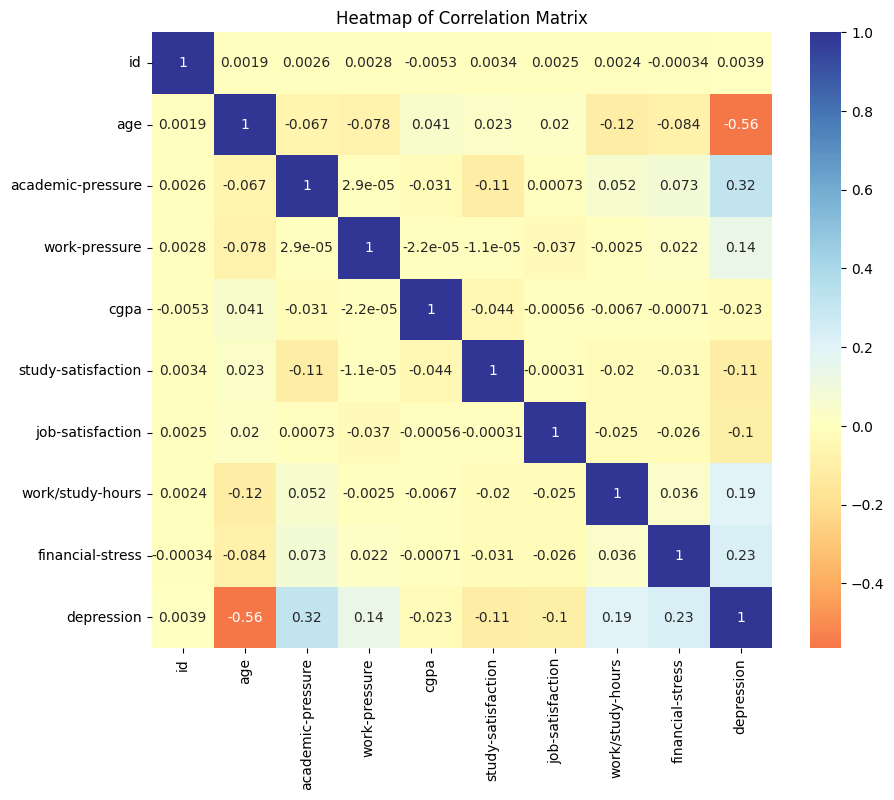

In [36]:
# Calculate the correlation matrix
correlation_matrix = train.corr(numeric_only=True)

# Create a heatmap with orange and blue colors
plt.figure(figsize=(10, 8))
fig = sns.heatmap(correlation_matrix, 
                  annot=True,         # Display correlation values
                  cmap='RdYlBu',      # Color scale with shades of red, yellow, and blue
                  center=0)           # Center the colormap at 0

# Add title
plt.title('Heatmap of Correlation Matrix')

# Show the plot
plt.show()

In [ ]:
# get categorical columns
cat_cols=train.columns[train.dtypes=='O'].to_list()
# get numerical columns
num_cols = [cols for cols in train.select_dtypes('number').columns if cols!= 'id' and cols!='depression']


In [ ]:
len(cat_cols) , len(num_cols)
num_cols

In [ ]:
cat_cols

In [ ]:
#df.isnull().sum()

## Handling missing value in categorical columns  
Classifying all the values having a value count of less than 100 to a different new class noise and fill the NaN values to new class missing.

In [ ]:
threshold=100
for col in df.select_dtypes('object').columns:
    # fill in all NaN by 'missing'
    df[col] = df[col].fillna('missing')
    # computes the frequency of each unique value in the column, including NaN values
    # sets the value of the column to "noise" for all rows where the boolean condition (value count is less than threshold) is true.
    df.loc[df[col].value_counts(dropna=False)[df[col]].values < threshold, col] = "noise"

In [ ]:
for col in num_cols:
        df[col]=df[col].fillna(0)

In [ ]:
#df.isnull().sum()

In [ ]:
#df.isnull().sum()/df.shape[0]*100

In [ ]:
mean[0]

In [ ]:
mean=df['academic-pressure'].mean()
print(mode)
df.profession=df.profession.fillna(mode.iloc[0])

In [ ]:
df['academic-pressure'].value_counts(dropna=False)

In [ ]:
def preprocess(df, missing_num=0, missing_cat=0):
    df=df.copy()
     # Change columns titles to lower case
    df.columns=df.columns.str.lower().str.replace(' ', '-').to_list()
    # get numerical columns
    num_cols = [cols for cols in df.select_dtypes('number').columns if cols!= 'id' and cols!='depression']
   
    # get categorical columns
    cat_cols=df.columns[df.dtypes=='O'].to_list()
    # Change categorical column content to lower case
    for col in cat_cols:
        df[col]=df[col].str.lower()
    if missing_cat=='Mode':
        for col in cat_cols:
            # fill in all NaN by the mode
            mode=df[col].mode()
            df[col] = df[col].fillna(mode.iloc[0])
    elif missing_cat==0:
        threshold=100
        for col in cat_cols:
            # fill in all NaN by 'missing'
            df[col] = df[col].fillna('missing')
            # computes the frequency of each unique value in the column, including NaN values
            # sets the value of the column to "noise" for all rows where the boolean condition (value count is less than threshold) is true.
            df.loc[df[col].value_counts(dropna=False)[df[col]].values < threshold, col] = "noise"
    else:
        print('Enter the correct value for missing_cat')
    if missing_num=='Mean': 
        for col in num_cols:
            mean=df[col].mean()
            df[col]=df[col].fillna(mean)
    elif missing_num=='Median':
        for col in num_cols:
            median=df[col].median()
            df[col]=df[col].fillna(median)
    elif missing_num==0:
         for col in num_cols:
            df[col]=df[col].fillna(0)
    else:
        print('Enter the correct value for missing_num')
    # remove name column as it does not affect the target
    cat_cols.remove('name')
    features=num_cols+cat_cols
    
    
    

    return features, df

  
    
    

In [ ]:
features, df=preprocess(train,0, 'Mode')
len(features) , df.shape
#df['academic-pressure'].value_counts(), df['profession'].value_counts()

## Base Model

In [ ]:
df.depression.value_counts(normalize=True)  # base accuracy is 82%


## Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score,classification_report

In [ ]:
def split_data(df, features):
    df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
    # reset index 
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    # get the target values
    y_train = df_train.depression.values
    y_val = df_val.depression.values
    y_test=df_test.depression.values
    # drop target
    del df_train['depression']
    del df_val['depression']
    del df_test['depression']
    train_dict=df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict=df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    test_dict=df_test[features].to_dict(orient='records')
    X_test = dv.transform(test_dict)
    print( df_train.shape,df_val.shape, df_test.shape)
    return df_train , X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test =split_data(df)

## Exploratory data analysis

In [ ]:
sns.histplot(data=df, x='age', bins=10, kde=True)
plt.title("Age Distribution")
plt.show()

In [ ]:
sns.catplot(data=df, x='sleep-duration', hue='dietary-habits', kind='count', height=5, aspect=2)
plt.title("Sleep Duration vs. Dietary Habits")
plt.show()


In [ ]:
sns.countplot(data=df, x='gender')
plt.title("Count of Gender")
plt.show()


In [ ]:
sns.countplot(data=df, x='working-professional-or-student')
plt.title("Count of Professionals vs. Students")
plt.show()


In [ ]:
df_train_full.depression.value_counts(normalize=True)

In [ ]:
global_mean = df_train_full.depression.mean()
round(global_mean, 3)

In [ ]:
df_train_full[cat_cols].nunique()

In [ ]:
female_mean = df_train_full[df_train_full.gender == 'female'].depression.mean()
print('gender == female:', round(female_mean, 3))

male_mean = df_train_full[df_train_full.gender == 'male'].depression.mean()
print('gender == male:  ', round(male_mean, 3))

In [ ]:
female_mean / global_mean

In [ ]:
male_mean / global_mean

In [ ]:
df_group = df_train_full.groupby(by='gender').depression.agg(['mean'])
df_group['diff'] = df_group['mean'] - global_mean
df_group['risk'] = df_group['mean'] / global_mean
df_group

In [ ]:
from IPython.display import display

In [ ]:
global_mean = df_train_full.depression.mean()
global_mean

In [ ]:
for col in cat_cols:
    df_group = df_train_full.groupby(by=col).depression.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

In [ ]:
from sklearn.metrics import mutual_info_score

In [ ]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.depression)

df_mi = df_train_full[cat_cols].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
    
    
display(df_mi.head())
display(df_mi.tail())

## Train

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble  import RandomForestClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
import time

In [ ]:
lr=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
dv = DictVectorizer(sparse=False)


In [ ]:
len(df_train.columns)
#df_train.head()

In [ ]:
train_dict=df_train[features].to_dict(orient='records')
print(train_dict[0])
X_train = dv.fit_transform(train_dict)

lr.fit(X_train, y_train)

In [ ]:
## Tree models
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=15)
dt.fit(X_train, y_train)

In [ ]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

In [ ]:
val_dict=df_val[features].to_dict(orient='records')
X_val=dv.transform(val_dict)
y_pred=lr.predict(X_val)

In [ ]:
accuracy_score(y_val, y_pred)

In [ ]:
import time

In [ ]:
def train_data(df, model):
    train_dict=df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    model.fit(X_train, y_train)


    return model

In [ ]:
t=time.time()
t

In [ ]:
t0=time.time()
LR=train(df_train, lr)
t1=time.time()
print(t1-t0)

## Evaluate

In [ ]:
def predict(X,model):
    y_pred=model.predict(X)
    return y_pred

In [ ]:
val_dict=df_val[features].to_dict(orient='records')
X_val=dv.transform(val_dict)
y_pred=predict(X_val, LR)
accuracy_score(y_val, y_pred)

In [ ]:
#df_train.academic-pressure.value_counts()

In [ ]:
cat_cols=['Working Professional or Student', 'Profession', 'Degree','Have you ever had suicidal thoughts ?']
num_cols=['Age','Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']
len(num_cols), len(cat_cols)

In [ ]:
num=list(map(lambda x: x.lower(), num_cols))
cat=list(map(lambda x: x.lower(), cat_cols))

In [ ]:
# try various parameters
features, df=preprocess(train)
featues=[num+cat]
df_train, X_train, y_train, X_val, y_val, X_test, y_test =split_data(df, features)
df_train.shape

In [ ]:
df_train.shape
df_train.head()

In [ ]:
# l2 is better  for Auc without imputation,  for Auc l1 is better with combo and for recall train only with l1 and l2 same
# with imputing mode for cat  not good for accuracy but no effect on auc and p and c

In [ ]:
#df_train.profession.value_counts(dropna=False), df_train['academic-pressure'].value_counts()
#df['academic-pressure'].value_counts()

## Model fine tuning

In [ ]:
from tqdm import tqdm

scores=[]
c_list=[0.045,0.05, 0.06, 0.07, 0.08,0.09,0.1,0.12, 0.2,0.3, 0.4, 0.5]
for l in ['l1','l2']:
    for c in tqdm(c_list):
        lr=LogisticRegression(penalty=l, solver='liblinear', C=c, max_iter=3000, random_state=42, class_weight=None)
        lr.fit(X_train, y_train)
        y_pred=lr.predict(X_val)
        accuracy=accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        y_predp = lr.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_predp)
        scores.append((l, c, accuracy, precision, recall, auc))
    

In [ ]:
df_scores = pd.DataFrame(scores, columns=['L','C', 'accuracy', 'precision', 'recall', 'auc'])
colors = ['black', 'blue']
l_values = ['l1', 'l2']

for l, col in zip(l_values, colors):
    df_subset = df_scores[df_scores.L == l]
    
    
    plt.plot(df_subset.C, df_subset.accuracy,
             color=col,
             label='Regularization=%s' % l)
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Train only ')
plt.show()

In [ ]:
colors = ['black', 'blue']
l_values = ['l1', 'l2']

for l, col in zip(l_values, colors):
    df_subset = df_scores[df_scores.L == l]
    
    
    plt.plot(df_subset.C, df_subset.auc,
             color=col,
             label='Regularization=%s' % l)
   
plt.xlabel('C (Regularization Strength)')
plt.ylabel('AUC')
plt.legend()
plt.savefig('LR train  ')
plt.show()

In [ ]:
colors = ['black', 'blue', 'green', 'orange']
l_values = ['l1', 'l1', 'l2', 'l2']
metrics = ['precision', 'recall']

# Plot each metric with a different color
for i, (l, metric) in enumerate(zip(l_values * 2, metrics * 2)):
    print(i, (l, metric))

In [ ]:
# Define more colors to differentiate each line
colors = ['black', 'blue', 'green', 'orange']
l_values = ['l1', 'l1', 'l2', 'l2']
metrics = ['precision', 'recall']

# Plot each metric with a different color
for i, (l, metric) in enumerate(zip(l_values , metrics * 2)):
    df_subset = df_scores[df_scores.L == l]
    
    # Plot precision and recall with different colors
    plt.plot(df_subset.C, df_subset[metric],
             color=colors[i],
             label=f'Regularization={l}, Metric={metric.capitalize()}')
    
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Score')
plt.legend()
plt.savefig('LR_train no impute')
plt.show()

In [ ]:
l='l2'
c=0.05
lr=LogisticRegression(penalty=l, solver='liblinear', C=c, max_iter=3000, random_state=42, class_weight=None)
lr.fit(X_train, y_train)
y_pred=lr.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)  # Print the raw confusion matrix

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (C={c}, regularization_type='{l}')")
plt.show()

In [ ]:
print(classification_report(y_val, y_pred, labels=[0,1]))

### Fine tuning with tree models

In [ ]:
# try various parameters
features, df=preprocess(train)
len(features)
df_train, X_train, y_train, X_val, y_val, X_test, y_test =split_data(df)

In [ ]:
from tqdm import tqdm
scores = []

for n in tqdm(range(1,20, 2)):
    dt = DecisionTreeClassifier(max_depth=n, random_state=1)
    dt.fit(X_train, y_train)
    y_pred=dt.predict(X_val)
    y_predp = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_predp)
    accuracy=accuracy_score(y_val, y_pred)
    
    scores.append((n, auc, accuracy))

In [ ]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'auc', 'accuracy'])
plt.plot(df_scores.max_depth, df_scores.accuracy) # top auc at estimator 160 to 180

In [ ]:
from tqdm import tqdm
scores = []
t0=time.time()
for n in tqdm(range(90,201, 10)):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred=rf.predict(X_val)
    y_predp = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_predp)
    accuracy=accuracy=accuracy_score(y_val, y_pred)
    
    scores.append((n, auc, accuracy))
t1=time.time()
print(t1-t0)

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc', 'accuracy'])

In [ ]:
plt.plot(df_scores.n_estimators, df_scores.accuracy) # top auc at estimator 160 to 180

In [ ]:
scores = []

for d in [5, 10, 15]:
    for n in range(150, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred=lr.predict(X_val)
        y_predp = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_predp)
        accuracy=accuracy=accuracy_score(y_val, y_pred)
        scores.append((d, n, auc, accuracy))

In [ ]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc', 'accuracy'])
plt.plot(df_scores.max_depth, df_scores.accuracy) # top auc at estimator 160 to 180

In [ ]:
test_dict=df_test[features].to_dict(orient='records')
X_test=dv.transform(test_dict)
y_pred=predict(X_test, LR)
accuracy_score(y_test, y_pred)

### Model Interpretation

In [ ]:
lr.coef_[0].shape

In [ ]:
len(dv.get_feature_names())

In [ ]:
dict(zip(dv.get_feature_names_out(), lr.coef_[0].round(3)))

## Submit

In [ ]:
len(test)

In [ ]:
features,df_test_submit= preprocess(test)
df_test_submit.shape, len(features)

In [ ]:
df_test_submit.isnull().sum()

In [ ]:
lr=LogisticRegression(solver='liblinear', C=0.05, max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

In [ ]:
test_submit_dict=df_test_submit[features].to_dict(orient='records')
X_test_submit=dv.transform(test_submit_dict)
y_pred=predict(X_test_submit, LR)
y_pred[:5]

In [ ]:
submission=pd.read_csv('sample_submission.csv')

In [ ]:
submission.head()

In [ ]:
submission['Depression']=y_pred

In [ ]:
submission.head(10)

In [ ]:
submission.Depression.value_counts(normalize=True)

In [ ]:
submission.to_csv('sub3.csv', index=False)